In [1]:
#Import Some Libraries
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

import scipy.linalg as la
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from numpy import linalg as LA
from scipy.linalg import fractional_matrix_power
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix
import matplotlib.cm as cm
from sklearn.manifold import LocallyLinearEmbedding as SklearnLLE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import pairwise_distances
from scipy.stats import mode as mode
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

# Fix randoom seed for reproducibility
import random
np.random.seed(42)

In [2]:
# Prepare data
demographic = pd.read_csv('../data/processed/demographic.csv')
severity = pd.read_csv('../data/processed/severity.csv', index_col=0)
severity = severity.drop('_uuid', axis =1 )
features = demographic.columns 
X = demographic.astype(np.float64)
X_arr = X.as_matrix()
y = (severity >= 4).sum(axis=1)

/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [7]:
#X.head()
severity_arr = severity.as_matrix()
severity_arr = severity_arr.T

/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [61]:
print(features)
#print(X.iloc[1,:])
#print(X.loc[0:20,'Population Group_Internally Displaced Persons (IDPs)':'Population Group_Returnees'].sum(axis = 1))
#print(X.loc[250:270,'Domain_central borno':'Domain_southern yobe'].sum(axis = 1))
#print(X.loc[350:370,'Head of Household Marital Status_Divorced':'Head of Household Marital Status_Widowed'].sum(axis = 1))
print(X.loc[:,'Head of Household Age'].max())
print(X.loc[X.loc[:,'Head of Household Age'] == 6, :])
#print(X.loc[:,'Total Household Members 6 months to 5 years old'])

#print(features[3:13])
#print(features[13:16])
#print(features[16:18])
#print(features[18:23])
print(features[34])


Index(['State_Adamawa', 'State_Borno', 'State_Yobe', 'Domain_central borno',
       'Domain_central yobe', 'Domain_east borno', 'Domain_mmc and jere',
       'Domain_northern adamawa', 'Domain_northern borno',
       'Domain_northern yobe', 'Domain_southern adamawa',
       'Domain_southern borno', 'Domain_southern yobe',
       'Population Group_Internally Displaced Persons (IDPs)',
       'Population Group_Non-displaced', 'Population Group_Returnees',
       'Respondent Sex_Female', 'Respondent Sex_Male',
       'Head of Household Marital Status_Divorced',
       'Head of Household Marital Status_Married, more than 1 partner',
       'Head of Household Marital Status_Married, only 1 partner',
       'Head of Household Marital Status_Single',
       'Head of Household Marital Status_Widowed', 'Head of Household - Y/N',
       'Respondent Age', 'Head of Household Age', 'Language - English',
       'Language - French', 'Number of Household Members',
       'Total Household Members 0-6 m

In [41]:
#For pairwise_dissimilarity function, we have to define global variables
#They cannot be given as input, since scipy's pdist function does not allow

global_respondent_age_range = X.loc[:,'Respondent Age'].max() - X.loc[:,'Respondent Age'].min()
global_head_age_range = X.loc[:,'Head of Household Age'].max() - X.loc[:,'Head of Household Age'].min()

#pop1:0-6month, pop2:6 month-5 years, pop3:5-18years, pop4: 18+ years
global_pop1_range = X.loc[:,'Total Household Members 0-6 months old'].max() - X.loc[:,'Total Household Members 0-6 months old'].min()
global_pop2_range = X.loc[:,'Total Household Members 6 months to 5 years old'].max() - X.loc[:,'Total Household Members 6 months to 5 years old'].min()
global_pop3_range = X.loc[:,'Total Household Members 5 years to 18 years old'].max() - X.loc[:,'Total Household Members 5 years to 18 years old'].min()
global_pop4_range = X.loc[:,'Total household members over 18 years old'].max() - X.loc[:,'Total household members over 18 years old'].min()

global_langHH_range = X.loc[:,'Languages in HH'].max() - X.loc[:,'Languages in HH'].min()





print(global_respondent_age_range)
print(global_head_age_range)
print(global_pop1_range)
print(global_pop2_range)
print(global_pop3_range)
print(global_pop4_range)
print(global_langHH_range)


81.0
94.0
10.0
0.0
20.0
29.0
6.0


In [8]:
def pairwise_dissimilarity_sectors(a,b):
    return np.sum(np.abs(a-b))

In [9]:
dissimilarity_sector = pairwise_distances(severity_arr, Y=None, metric=pairwise_dissimilarity_sectors, n_jobs=1)

In [10]:
print(dissimilarity_sector)

[[    0.   33997.   32310.   54558.   40905.   21010.37 27030.   44908.  ]
 [33997.       0.   21321.   29449.   22042.   27366.01 23915.   24711.  ]
 [32310.   21321.       0.   30140.   22769.   26260.05 22408.   25508.  ]
 [54558.   29449.   30140.       0.   18269.   45038.83 35960.   15108.  ]
 [40905.   22042.   22769.   18269.       0.   31838.25 25093.   17811.  ]
 [21010.37 27366.01 26260.05 45038.83 31838.25     0.   20289.71 35075.55]
 [27030.   23915.   22408.   35960.   25093.   20289.71     0.   25900.  ]
 [44908.   24711.   25508.   15108.   17811.   35075.55 25900.       0.  ]]


In [42]:
#Define the pairwise dissimilarity measure
def pairwise_dissimilarity(a,b):
    total_diff = 0
    
    #Compare domains 
    #Explanation: If they are the same, absolute of diff will be 0, otherwise [0..1..0..1....] (there will be two 1s)
    diff_domain = np.sum(np.abs(a[3:13] - b[3:13]))/2
    total_diff+=diff_domain
    
    #Compare population
    diff_pop = np.sum(np.abs(a[13:16] - b[13:16]))/2
    total_diff+=diff_pop
    
    #Compare respondent sex
    diff_sex = np.sum(np.abs(a[16:18] - b[16:18]))/2
    total_diff+=diff_sex
    
    #Compare the marital status of the head
    diff_marital = np.sum(np.abs(a[18:23] - b[18:23]))/2
    total_diff+=diff_marital
    
    #Compare if the respondent is head or not
    diff_head = np.sum(np.abs(a[23] - b[23]))
    total_diff+=diff_head
    
    #Compare respondent age
    diff_resp_age = np.abs(a[24] - b[24])/global_respondent_age_range
    total_diff+=diff_resp_age
    
    #Compare head age
    diff_head_age = np.abs(a[25] - b[25])/global_head_age_range
    total_diff+=diff_head_age
    
    #Compare language english
    diff_eng = np.abs(a[26] - b[26])
    total_diff+=diff_eng
    
    #Compare language french
    diff_fr = np.abs(a[27] - b[27])
    total_diff+=diff_fr
    
    #Compate 0-6 month pop.
    diff_pop1 = np.abs(a[29] - b[29])/global_pop1_range
    total_diff+=diff_pop1
    
    #Compate 5-18 years pop.
    diff_pop3 = np.abs(a[32] - b[32])/global_pop3_range
    total_diff+=diff_pop3
    
    #Compate 18+ years pop.
    diff_pop4 = np.abs(a[33] - b[33])/global_pop4_range
    total_diff+=diff_pop4
    
    #Compare vulnerability
    diff_vul = np.abs(a[31] - b[31])
    total_diff+=diff_vul
    
    #Compare languages in HH
    diff_langHH = np.abs(a[34] - b[34])/global_langHH_range
    total_diff+=diff_langHH
    
    
    return total_diff

In [43]:
%%time
#Try pairwise_dissimilarity
#Get 2000 random sample
sample_indices = random.sample(range(0,X_arr.shape[0]),2000)

dissimilarity_ = pairwise_distances(X=X_arr[sample_indices,:], Y=None, metric=pairwise_dissimilarity, n_jobs=1)
print(dissimilarity_.shape)

(2000, 2000)
CPU times: user 1min 24s, sys: 65.3 ms, total: 1min 24s
Wall time: 1min 24s


In [90]:
#Get corresponding y values
y_subsampled = y[sample_indices]

In [11]:
#Create Constant Shift Embedding class to apply transformation
class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        self.Sc_tilde = None
        self.D = None
        # Add/change parameters, if necessary.
    
    def fit(self, D):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """

        # Save data
        self.D = D
        
        ## IMPLEMENT THIS METHOD
        
        #Number of elements
        N = self.D.shape[0]
        
        #Centralizer Q
        
        Q = np.identity(N) - np.ones((N,N))/N
        
        #Calculate Dc and Sc
        Dc = np.matmul(Q, np.matmul(self.D,Q))
        Sc = -Dc/2
        
        #Find eigenvalue of Sc
        w,v = LA.eig(Sc)
        eig_min = min(w)
        
        #Calculate D_0 and D_tilde
        D_0 = -2*eig_min
        D_tilde = self.D + D_0 * (np.ones((N,N)) - np.identity(N))
        
        #Calculate Sc_tilde
        self.Sc_tilde = -1/2 * np.matmul(Q, np.matmul(D_tilde,Q))
        
    def get_embedded_vectors(self, p):
        """Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        
        ## IMPLEMENT THIS METHOD
        
        #Calculate eigenvalues and vectors
        w,v = LA.eig(self.Sc_tilde)
        descending_w = np.sort(w)[::-1]
        descending_argw = np.argsort(w)[::-1]
        
        selected_args = descending_argw[0:p];
        
        V_p = np.take(v, selected_args, axis=1)
        Diag_p = np.diag(descending_w[0:p])
        
        Xp = np.matmul(V_p, fractional_matrix_power(Diag_p, 0.5))
        
        return Xp
        

In [12]:
CSE = ConstantShiftEmbedding()

In [13]:
CSE.fit(dissimilarity_sector)

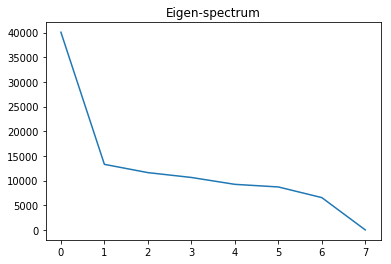

In [15]:
## Compute eigen-spectrum
w,v = LA.eig(CSE.Sc_tilde)
descending_w = np.sort(w)[::-1]
#plt.plot(np.arange(0,len(y_subsampled),1), descending_w)
plt.plot(np.arange(0,8,1), descending_w)
plt.title("Eigen-spectrum")
plt.show()

In [18]:
## Determine a good cut-off value
p_opt = np.argmin(descending_w > 13000) ## change accordingly
print("Chosen cut-off value is: ", p_opt)

Chosen cut-off value is:  2


In [19]:
## Plot spectrum and indicate the cut-off value on the spectrum
plt.plot(np.arange(0,len(y_subsampled),1), descending_w)
plt.plot([p_opt, p_opt], [0, np.max(descending_w)], 'k--', lw=1)
plt.plot([0, len(y_subsampled)-1], [200, 200], 'k--', lw=1)
plt.title("Eigen-spectrum with cut-off point and its value")
plt.show()

NameError: name 'y_subsampled' is not defined

In [129]:
print(np.unique(y_subsampled))

[0 1 2 3 4 5 6 7]


For predicted label 0, the histogram of truth label is:
(array([10, 22, 47, 46, 41, 15,  2]), array([0, 1, 2, 3, 4, 5, 6, 7]))
For predicted label 1, the histogram of truth label is:
(array([ 9, 34, 40, 65, 54, 18,  8]), array([0, 1, 2, 3, 4, 5, 6, 7]))
For predicted label 2, the histogram of truth label is:
(array([11, 25, 61, 70, 52, 33,  2]), array([0, 1, 2, 3, 4, 5, 6, 7]))
For predicted label 3, the histogram of truth label is:
(array([ 25,  47,  68, 103,  83,  33,   7]), array([0, 1, 2, 3, 4, 5, 6, 7]))
For predicted label 4, the histogram of truth label is:
(array([ 7, 40, 56, 64, 47, 32,  4]), array([0, 1, 2, 3, 4, 5, 6, 7]))
For predicted label 5, the histogram of truth label is:
(array([17, 55, 64, 76, 43, 22,  0]), array([0, 1, 2, 3, 4, 5, 6, 7]))
For predicted label 6, the histogram of truth label is:
(array([ 6, 20, 41, 56, 40,  8,  4]), array([0, 1, 2, 3, 4, 5, 6, 7]))
For predicted label 7, the histogram of truth label is:
(array([12, 43, 58, 71, 57, 23,  3]), array([0, 

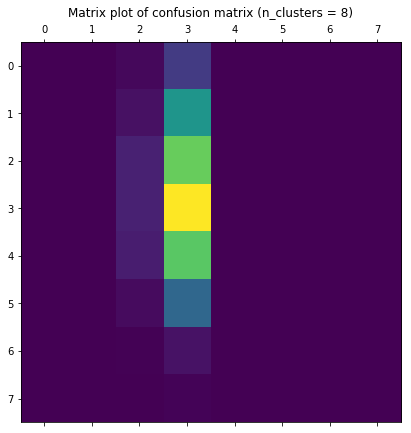

In [138]:
def assignments(truth_labels, predicted_labels):
    assignment_vec = np.zeros(len(truth_labels))
    for i in np.unique(predicted_labels):
        print('For predicted label '+str(i)+', the histogram of truth label is:')
        print(np.histogram(truth_labels[predicted_labels == i], bins = np.arange(8)))
        assignment = mode(truth_labels[predicted_labels == i])[0]
        assignment_vec[predicted_labels == i] = assignment
    conf_matrix = confusion_matrix(truth_labels,assignment_vec)
    return(conf_matrix)

Xp = CSE.get_embedded_vectors(p_opt)
Xp = Xp.real
kmeans = KMeans(n_clusters=8,random_state=42)
kmeans.fit(Xp)
labels = kmeans.predict(Xp)

conf_matrix = assignments(y_subsampled, labels)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_title('Matrix plot of confusion matrix (n_clusters = '+str(8)+')')
ax.matshow(conf_matrix)
plt.show()

In [112]:
print(Xp[1])

[ 1.12588372-3.30962570e-33j  0.40000168+5.94403230e-33j
 -0.42360621-4.49675427e-33j -0.09307679-4.69856052e-33j
  0.25906595+5.08876779e-33j -0.53204912+8.20857840e-33j
  0.13257064+1.99229072e-32j  0.02742525+9.71101251e-33j
 -0.09070914+8.98834225e-33j  0.55696222-2.12800842e-33j
 -0.24106593+1.20767974e-31j -0.00918136+2.58601073e-32j
 -0.08480045-1.17277375e-32j -0.16637574+4.42874875e-32j
  0.09244505+5.02273845e-32j  0.18898874-7.05612133e-32j
  0.29875759-1.60330697e-32j -0.0795749 -9.76855070e-33j
 -0.00315632-2.27302198e-32j -0.01033382-6.95136002e-32j
 -0.28025509-3.20169759e-32j  0.12127744-7.72130729e-32j
  0.06350023+1.65360106e-31j  0.040123  -1.23933692e-31j
  0.09336107-8.08264728e-32j -0.06838754+2.53336369e-33j
 -0.03682514-1.52067184e-31j -0.0747525 +6.46103740e-32j
 -0.02150985+1.13337956e-28j  0.00532039+8.18877021e-25j]


In [123]:
print(np.histogram(labels, bins=7))
print(np.histogram(y_subsampled, bins=7))
print(np.unique(labels))

(array([177, 331, 160, 320, 226, 281, 505]), array([0., 1., 2., 3., 4., 5., 6., 7.]))
(array([ 97, 286, 435, 551, 417, 184,  30]), array([0., 1., 2., 3., 4., 5., 6., 7.]))
[0 1 2 3 4 5 6 7]


In [34]:
#Cluster the sectors 
Xp = CSE.get_embedded_vectors(p_opt)
Xp = Xp.real
kmeans = KMeans(n_clusters=7,random_state=42)
kmeans.fit(Xp)
labels = kmeans.predict(Xp)
print(labels)
print(severity.columns)

[3 1 1 4 2 6 0 5]
Index(['ERL', 'WASH', 'Health', 'Nutrition', 'Education', 'Food',
       'Shelter/NFI', 'Protection'],
      dtype='object')


# CLUSTERING OF SECTORS

## Cluster 1: WASH, Health
## Cluster 2: ERL, Food
## Cluster 3: Shelter
## Cluster 4: Nutrition, Education, Protection

In [35]:
severity.head()

,ERL,WASH,Health,Nutrition,Education,Food,Shelter/NFI,Protection
0,3.0,4.0,0.0,0.0,0.0,1.33,2,0
1,2.0,0.0,0.0,0.0,0.0,3.66,4,0
2,2.0,0.0,0.0,0.0,3.0,3.66,4,0
3,0.0,0.0,0.0,0.0,0.0,1.66,4,0
4,0.0,0.0,0.0,0.0,0.0,6.16,2,0


In [38]:
severity['C1'] = severity.loc[:,['WASH', 'Health']].sum(axis = 1)/2
severity['C2'] = severity.loc[:,['ERL', 'Food']].sum(axis = 1)/2
severity['C3'] = severity.loc[:,'Shelter/NFI'].values
severity['C4'] = severity.loc[:,['Nutrition', 'Education', 'Shelter/NFI']].sum(axis = 1)/3
severity.head()

,ERL,WASH,Health,Nutrition,Education,Food,Shelter/NFI,Protection,C1,C2,C3,C4
0,3.0,4.0,0.0,0.0,0.0,1.33,2,0,2.0,2.165,2,0.666667
1,2.0,0.0,0.0,0.0,0.0,3.66,4,0,0.0,2.830,4,1.333333
2,2.0,0.0,0.0,0.0,3.0,3.66,4,0,0.0,2.830,4,2.333333
3,0.0,0.0,0.0,0.0,0.0,1.66,4,0,0.0,0.830,4,1.333333
4,0.0,0.0,0.0,0.0,0.0,6.16,2,0,0.0,3.080,2,0.666667


In [39]:
cluster_score_matrix = severity.loc[:,['C1', 'C2', 'C3', 'C4']].as_matrix()
print(cluster_score_matrix)

[[2.         2.165      2.         0.66666667]
 [0.         2.83       4.         1.33333333]
 [0.         2.83       4.         2.33333333]
 ...
 [4.         5.995      4.         2.33333333]
 [2.5        1.         0.         0.        ]
 [3.5        4.58       6.         2.        ]]


/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [44]:
print(np.argmax(cluster_score_matrix, axis=1))
y_cluster = np.argmax(cluster_score_matrix, axis=1)
y_cluster_subsampled = y_cluster[sample_indices]

[1 2 2 ... 1 0 2]


In [45]:
CSE2 = ConstantShiftEmbedding()
CSE2.fit(dissimilarity_)

/anaconda3/envs/slt-ce/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


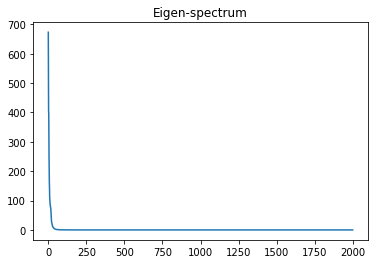

In [47]:
## Compute eigen-spectrum
w,v = LA.eig(CSE2.Sc_tilde)
descending_w = np.sort(w)[::-1]
plt.plot(np.arange(0,len(y_cluster_subsampled),1), descending_w)
plt.title("Eigen-spectrum")
plt.show()

In [56]:
## Determine a good cut-off value
p_opt = np.argmin(descending_w > 100) ## change accordingly
print("Chosen cut-off value is: ", p_opt)

Chosen cut-off value is:  11


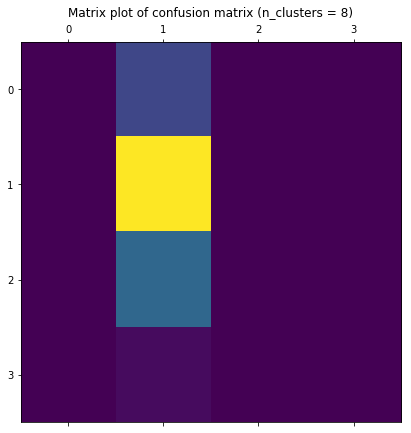

In [58]:
def assignments(truth_labels, predicted_labels):
    assignment_vec = np.zeros(len(truth_labels))
    for i in np.unique(predicted_labels):
        #print('For predicted label '+str(i)+', the histogram of truth label is:')
        #print(np.histogram(truth_labels[predicted_labels == i], bins = np.arange(8)))
        assignment = mode(truth_labels[predicted_labels == i])[0]
        assignment_vec[predicted_labels == i] = assignment
    conf_matrix = confusion_matrix(truth_labels,assignment_vec)
    return(conf_matrix)

Xp = CSE2.get_embedded_vectors(p_opt)
Xp = Xp.real
kmeans = KMeans(n_clusters=4,random_state=42)
kmeans.fit(Xp)
labels = kmeans.predict(Xp)

conf_matrix = assignments(y_cluster_subsampled, labels)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_title('Matrix plot of confusion matrix (n_clusters = '+str(8)+')')
ax.matshow(conf_matrix)
plt.show()

In [59]:
np.histogram(labels)

(array([403,   0,   0, 506,   0,   0, 791,   0,   0, 300]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]))

In [60]:
np.histogram(y_cluster_subsampled)

(array([ 269,    0,    0, 1270,    0,    0,  424,    0,    0,   37]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]))

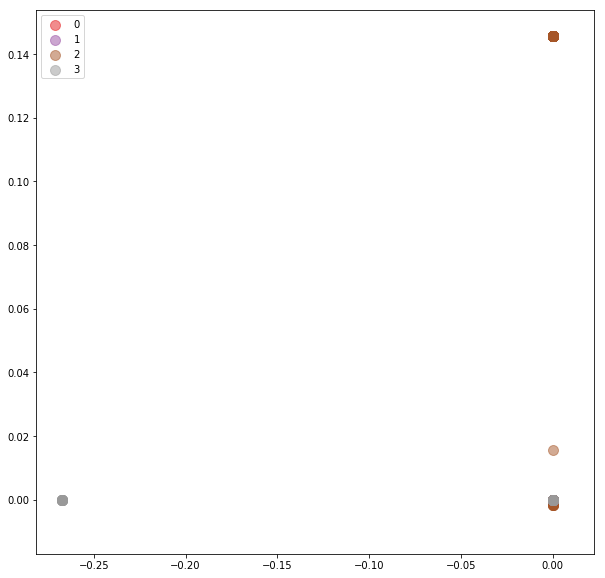

In [67]:
sklLLE = SklearnLLE(random_state=42)
sklLLE.fit(Xp)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
colors = cm.Set1(np.linspace(0, 1, 4))
for prediction in range(4):
        idx = (labels == prediction)
        plt.scatter(sklLLE.embedding_[idx, 0], sklLLE.embedding_[idx, 1], alpha=.5, label=prediction, c = colors[prediction], s=100)
plt.legend()
plt.show()

In [68]:
Xp

array([[-0.29055008,  0.34935971, -0.75534517, ...,  0.00980757,
         0.01342278,  0.09782458],
       [ 0.15124929, -0.0413724 ,  0.91103975, ..., -0.14387808,
         0.44559687, -0.0024373 ],
       [ 0.34043009, -0.41579249,  0.61935801, ..., -0.00870887,
        -0.15057216,  0.07505951],
       ...,
       [-0.2687805 ,  0.38998316, -0.6693561 , ...,  0.01955114,
        -0.05513748, -0.03896232],
       [-0.46774063, -0.34938752,  0.66806351, ..., -0.04665352,
        -0.21929427, -0.23463823],
       [ 0.41276396,  0.30713021, -0.80815621, ...,  0.63543347,
         0.14571775, -0.07063519]])

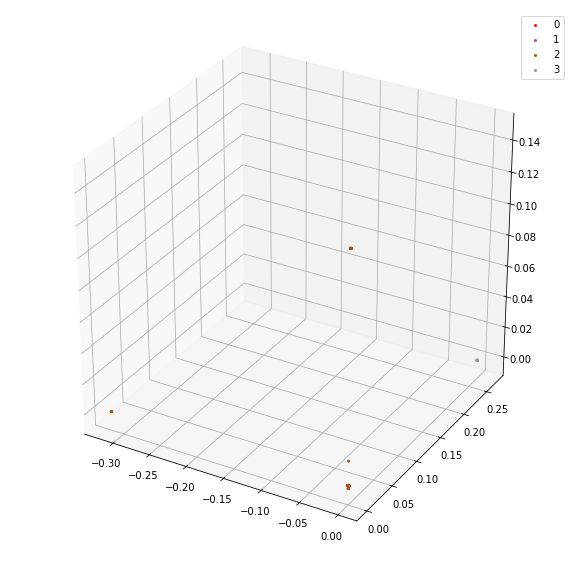

In [70]:
sklLLE = SklearnLLE(random_state=42, n_components=3)
sklLLE.fit(Xp)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors = cm.Set1(np.linspace(0, 1, 4))
for prediction in range(4):
        idx = (labels == prediction)
        ax.scatter(sklLLE.embedding_[idx, 0], sklLLE.embedding_[idx, 1], sklLLE.embedding_[idx, 2], alpha=1, label=prediction, c = colors[prediction], s=4)
plt.legend()
plt.show()